# Praktikum Pengantar Pembelajaran Mesin


---
## Bab 9. K-Means Clustering


### 1) Import Data

Unduh dataset yang akan digunakan pada praktikum kali ini. Anda dapat menggunakan aplikasi wget untuk mendowload dataset dan menyimpannya dalam Google Colab. Jalankan cell di bawah ini untuk mengunduh dataset

In [67]:
! wget https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv

--2024-05-19 19:38:52--  https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3975 (3.9K) [text/plain]
Saving to: ‘iris.csv.3’

iris.csv.3          100%[===================>]   3.88K  --.-KB/s    in 0s      

2024-05-19 19:38:52 (31.9 MB/s) - ‘iris.csv.3’ saved [3975/3975]



Setelah dataset berhasil diunduh, langkah berikutnya adalah membaca dataset dengan memanfaatkan fungsi **readcsv** dari library pandas. Lakukan pembacaan berkas csv ke dalam dataframe dengan nama **data** menggunakan fungsi **readcsv**. Jangan lupa untuk melakukan import library pandas terlebih dahulu


In [68]:
import pandas as pd
import numpy as np

data = pd.read_csv('iris.csv')



Cek isi dataset Anda dengan menggunakan perintah **head()**

In [69]:
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


## 2) Preprocessing

Sebelum dilakukan proses clustering, perlu dilakukan beberapa tahapan pemrosesan awal data. Tahapan pertama adalah memisahkan kelas data dari dataframe, karena algoritma K-Means tidak memerlukan informasi kelas. Pisahkan kelas data ke dalam sebuah variabel bernama kelas.

In [70]:
kelas = data.pop('variety')

Pada praktikum kali ini, kita akan memvisualisasikan data hasil clustering menggunakan [scatter plot](https://en.wikipedia.org/wiki/Scatter_plot). Scatter plot hanya dapat digambarkan dalam bentuk 2 dimensi, dengan demikian data yang digunakan juga hanya terdiri dari 2 fitur. Hapus fitur **petal_length** dan **petal_width** pada data, sehingga fitur yang digunakan adalah **sepal_length** dan **sepal_width**

In [71]:
del data['petal.length']
del data['petal.width']

Salah satu tahap pada algoritma K-Means adalah perhitungan jarang Euclidean. Agar tidak ada fitur yang mendominasi pada perhitungan jarak, maka perlu dilakukan normalisasi terlebih dahulu agar rentang nilai setiap fitur sama. Implementasikan metode normalisasi min-max menggunakan fungsi bernama **minmax** pada cell di bawah ini. (Catatan : Anda pernah membuat fungsi ini di Praktikum 2)

In [72]:
def minmax (df_input):
  df_input = df_input.copy()
  list_fitur = df_input.columns[:-1]
  for fitur in list_fitur:
    max = df_input[fitur].max()
    min = df_input[fitur].min()
    df_input[fitur] = (df_input[fitur]-min)/(max-min)
  return df_input

Lakukan normalisasi data dan simpan hasilnya pada variabel bernama **data_normal**




In [73]:
data_normal = minmax(data)

Tampilkan isi dataframe **data_normal**

In [74]:
data_normal

,sepal.length,sepal.width
0,0.222222,3.5
1,0.166667,3.0
2,0.111111,3.2
3,0.083333,3.1
4,0.194444,3.6
...,...,...
145,0.666667,3.0
146,0.555556,2.5
147,0.611111,3.0
148,0.527778,3.4


## 3) Visualisasi data

Visualisasi data dilakukan untuk memahami struktur dari data. Informasi ini dapat digunakan untuk mengetahui cara pembentukan cluster yang baik. Visualisasikan **data_normal** menggunakan scatter plot. Gunakan library matplotlib.pyplot

[]

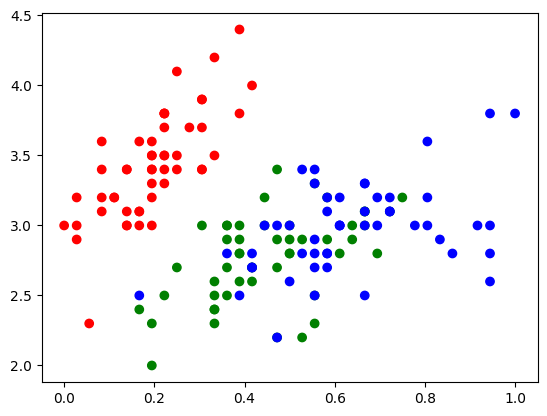

In [75]:
import matplotlib.pyplot as plt
warna = {'Setosa':'red', 'Versicolor':'green', 'Virginica':'blue'}
plt.scatter(data_normal['sepal.length'],data_normal['sepal.width'],c=kelas.map(warna))
plt.plot()

## 4) K-Means Clustering

Sebelum mengimplementasikan algoritma K-Means, perlu dilakukan implementasi perhitungan jarak. K-Means pada praktikum ini menggunakan perhitungan jarak Euclidean. Implementasikan perhitungan jarak Euclidean menggunakan fungsi bernama **euclidean** pada cell di bawah ini

In [76]:
def euclidean(data1,data2):
  jarak = np.square(data1-data2)
  jarak = np.sum(jarak)
  return np.sqrt(jarak)

Langkah selanjutnya adalah implementasi algoritma K-Means. Tahapan-tahapan dalam algoritma K-Means adalah:


1.   Penentuan keanggotaan cluster secara acak
2.   Hitung centroid berdasarkan data yang ada di masing-masing cluster
3.   Alokasikan masing-masing data ke centroid terdekat
4.   Kembali ke langkah 2 selama kondisi berhenti belum terpenuhi. Iterasi berhenti jika salah satu kondisi berikut terpenuhi:
     a. Tidak ada perubahan keanggotaan cluster
     
     b. Iterasi melebihi parameter *iter_max*

Implementasikan algoritma K-Means menggunakan fungsi bernama **kmeans** pada cell di bawah ini. Fungsi **kmeans** memiliki 3 parameter input, yaitu data, K, dan iter_max



In [77]:
from random import randint
import copy
def kmeans(data_input, k, iter_max=200):
  n_data = data_input.shape[0]
  n_fitur = data_input.shape[1]
  iter = 1
  cluster = np.array([randint(0,k-1) for i in range(n_data)])
  centroid = np.zeros((k,n_fitur))
  cluster_tidak_berubah = False
  while cluster_tidak_berubah==False and iter<iter_max:
    jarak = np.zeros((n_data,k))
    for i in range(k):
      centroid[i,:]=data_input.iloc[np.where(cluster==i)[0]].mean().tolist()
    for i in range(n_data):
      for j in range(k):
        jarak[i][j]=euclidean(data_input.iloc[i],centroid[j])
    cluster_baru = [np.argmin(jarak[i]) for i in range(n_data)]
    cluster_tidak_berubah = np.array_equal(cluster_baru,cluster)
    cluster = np.array(copy.deepcopy(cluster_baru))
    iter+=1
  return cluster_baru

In [78]:
cluster = kmeans(data_normal, 3)

Tampilkan keanggotaan cluster pada masing-masing data


In [79]:
print(cluster)

[2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1]


Tampilkan hasil clustering menggunaka scatter plot

[]

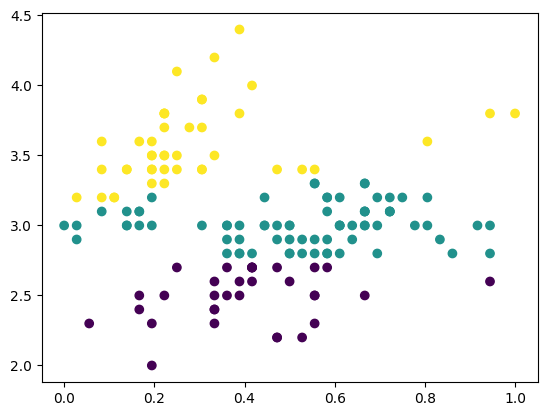

In [80]:
import matplotlib.pyplot as plt
plt.scatter(data_normal['sepal.length'], data_normal['sepal.width'], c=cluster)
plt.plot()

## TUGAS
Pada tugas kali ini Anda mengidentifikasikan pasangan fitur apa yang menghasilkan cluster yang ideal pada K-Means menggunakan data Iris.

Buatlah plot untuk setiap pasangan fitur yang mungkin.

In [81]:
data_i = pd.read_csv('iris.csv')

In [82]:
data_i.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [83]:
kelas_i = data_i.pop('variety')

In [84]:
data_inormal = minmax(data_i)
data_inormal

,sepal.length,sepal.width,petal.length,petal.width
0,0.222222,0.625000,0.067797,0.2
1,0.166667,0.416667,0.067797,0.2
2,0.111111,0.500000,0.050847,0.2
3,0.083333,0.458333,0.084746,0.2
4,0.194444,0.666667,0.067797,0.2
...,...,...,...,...
145,0.666667,0.416667,0.711864,2.3
146,0.555556,0.208333,0.677966,1.9
147,0.611111,0.416667,0.711864,2.0
148,0.527778,0.583333,0.745763,2.3


[]

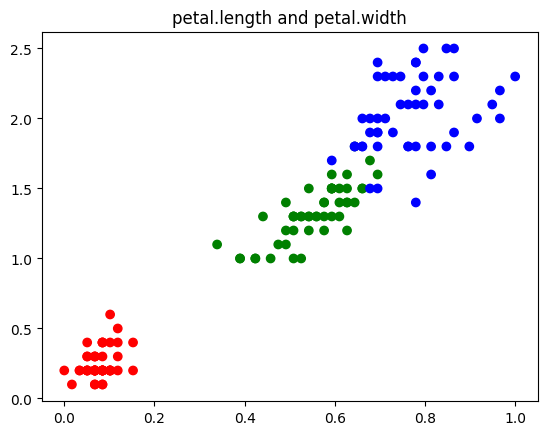

In [85]:
data_1 = data_inormal.copy()
warna_i = {'Setosa':'red', 'Versicolor':'green', 'Virginica':'blue'}
plt.scatter(data_inormal['petal.length'],data_inormal['petal.width'],c=kelas.map(warna_i))
plt.title('petal.length and petal.width')
plt.plot()

[]

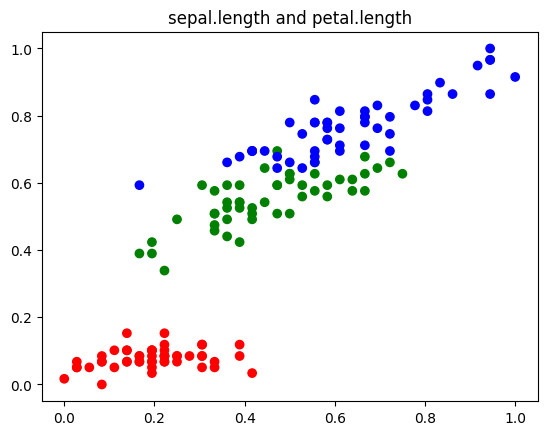

In [86]:
data_2 = data_inormal.copy()
warna_i = {'Setosa':'red', 'Versicolor':'green', 'Virginica':'blue'}
plt.scatter(data_inormal['sepal.length'],data_inormal['petal.length'],c=kelas.map(warna_i))
plt.title('sepal.length and petal.length')
plt.plot()

[]

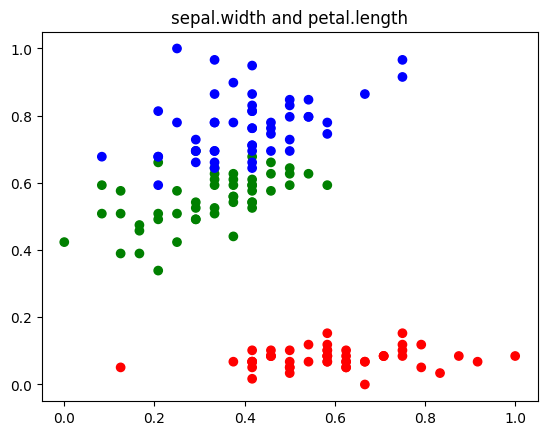

In [87]:
data_3 = data_inormal.copy()
warna_t = {'Setosa':'red', 'Versicolor':'green', 'Virginica':'blue'}
plt.scatter(data_inormal['sepal.width'],data_inormal['petal.length'],c=kelas.map(warna_i))
plt.title('sepal.width and petal.length')
plt.plot()

[]

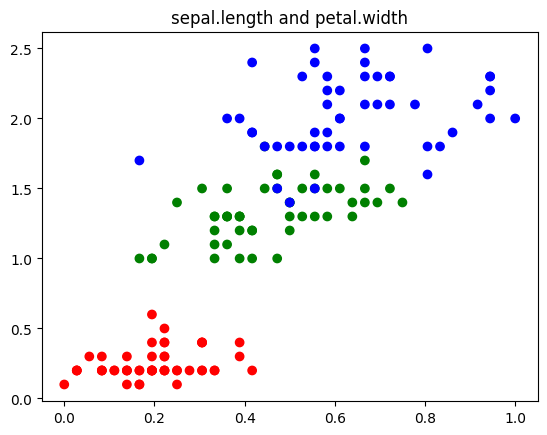

In [88]:
data_4 = data_inormal.copy()
warna_t = {'Setosa':'red', 'Versicolor':'green', 'Virginica':'blue'}
plt.scatter(data_inormal['sepal.length'], data_inormal['petal.width'], c=kelas.map(warna_i))
plt.title('sepal.length and petal.width')
plt.plot()

[]

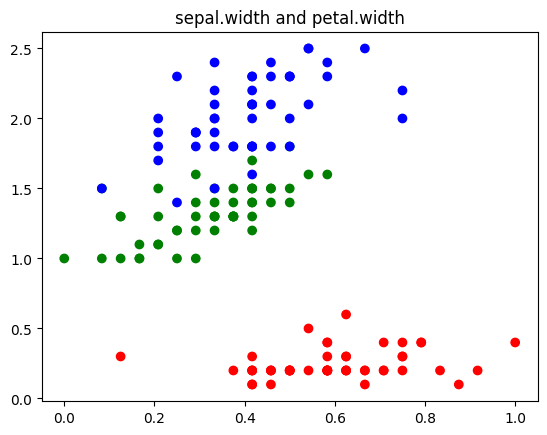

In [89]:
data_5 = data_inormal.copy()
warna_t = {'Setosa':'red', 'Versicolor':'green', 'Virginica':'blue'}
plt.scatter(data_inormal['sepal.width'], data_inormal['petal.width'], c=kelas.map(warna_i))
plt.title('sepal.width and petal.width')
plt.plot()

Identifikasikan pasangan fitur apa yang dapat membedakan ketiga kelas dengan baik

Kombinasi Petal Length and Petal Width merupakan pilihan terbaik untuk membedakan ketiga kelas Iris (Setosa, Versicolor, Virginica) karena memberikan pemisahan yang sangat jelas antar kelas. Setosa dapat dengan mudah dibedakan dari dua kelas lainnya melalui nilai yang sangat rendah pada kedua fitur ini, sedangkan Versicolor dan Virginica masih dapat dibedakan walaupun lebih dekat satu sama lain.

Lakukan clustering menggunakan K-Means dengan k=3, apakah cluster yang dihasilkan juga terpisah dengan baik? Gunakan scatter plot untuk melihat hasil clustering

In [90]:
cluster_1 = kmeans(data_1,3)

In [91]:
print(cluster_1)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[]

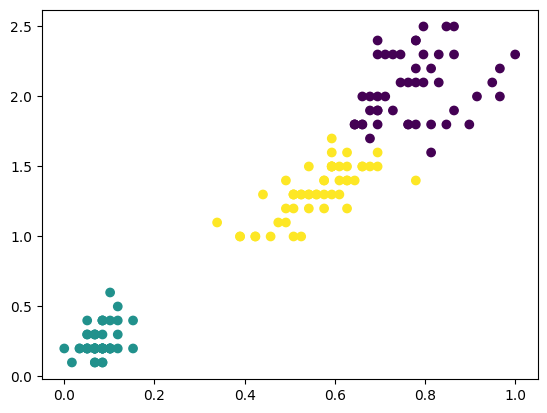

In [92]:
import matplotlib.pyplot as plt
plt.scatter(data_inormal['petal.length'], data_inormal['petal.width'], c = cluster_1)
plt.plot()

In [93]:
cluster_2 = kmeans(data_2,3)

In [94]:
print(cluster_2)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[]

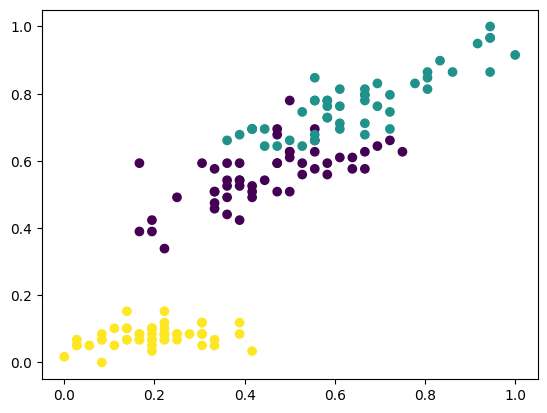

In [95]:
import matplotlib.pyplot as plt
plt.scatter(data_inormal['sepal.length'], data_inormal['petal.length'], c = cluster_2)
plt.plot()

In [96]:
cluster_3 = kmeans(data_3,3)

In [97]:
print(cluster_3)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[]

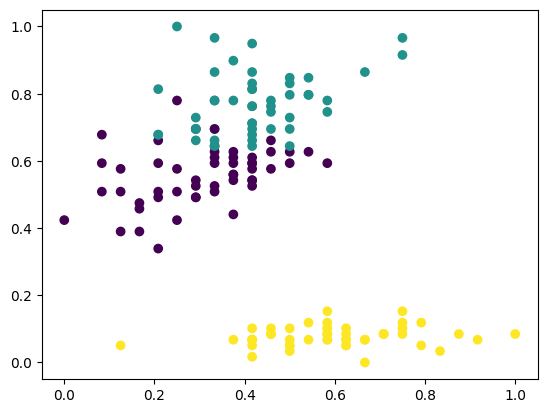

In [98]:
import matplotlib.pyplot as plt
plt.scatter(data_inormal['sepal.width'],data_inormal['petal.length'], c = cluster_3)
plt.plot()

In [99]:
cluster_4 = kmeans(data_4,3)

In [100]:
print(cluster_4)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[]

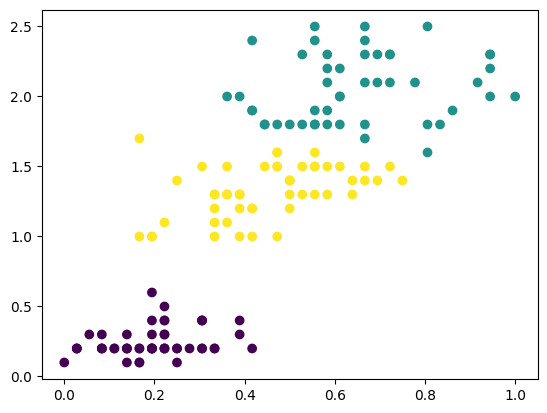

In [101]:
import matplotlib.pyplot as plt
plt.scatter(data_inormal['sepal.length'],data_inormal['petal.width'], c = cluster_4)
plt.plot()

In [102]:
cluster_5 = kmeans(data_5,3)

In [103]:
print(cluster_5)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[]

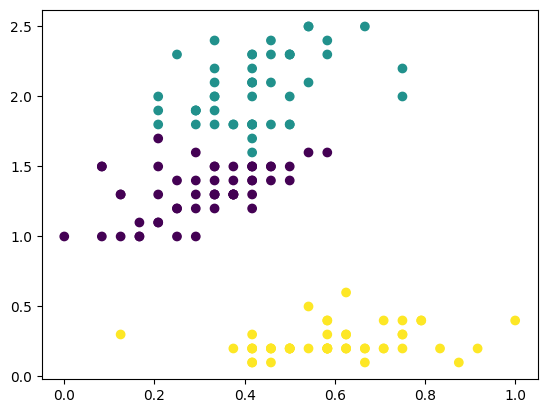

In [104]:
import matplotlib.pyplot as plt
plt.scatter(data_inormal['sepal.width'],data_inormal['petal.width'], c = cluster_5)
plt.plot()

[Apakah hasilnya baik? Mengapa?]

Setelah melalui proses pengelompokan menggunakan algoritma K-Means pada semua kombinasi kelas yang disebutkan di atas, hasil yang diperoleh sangat memuaskan, bahkan melebihi harapan. Keberhasilan ini terlihat terutama dari kelas Iris Setosa, Iris Versicolor, dan tentu saja Iris Virginica, yang dapat teridentifikasi dengan jelas melalui kolom variety yang telah ditentukan saat kita memisahkan setiap kelas ke dalam variabel kelas dan kelas_i. Dengan demikian, setelah pengelompokan selesai dilakukan, hasil yang baik dapat terlihat dengan jelas.

Ahmad Zaki 225150201111025:)